In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.ndimage as ndimage
import skimage

In [2]:
image = np.load('data/kidney/test/input/case_00011.npy')
label = np.load('data/kidney/test/label/case_00011.npy')
# WHD -> DHW
image = np.transpose(image, (2, 1, 0))
label = np.transpose(label, (2, 1, 0))

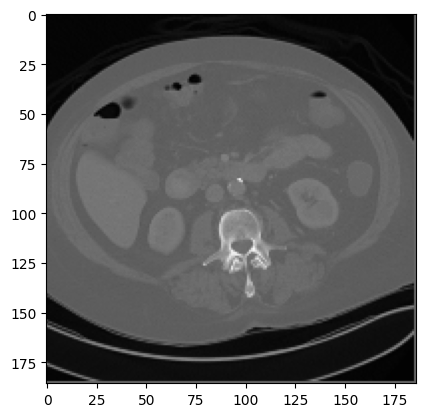

In [3]:
plt.imshow(image[64, ...], cmap='gray')

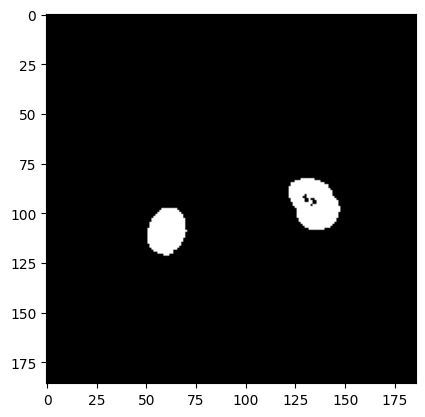

In [4]:
plt.imshow(label[64, ...], cmap='gray')

In [23]:
def get_affine_from_bbox_3d(z, y, x, d, h, w, original_shape):
  """
  Returns an affine transformation matrix in OpenCV-expected format that
  will crop the image to the bounding box.
  """
  original_d, original_h, original_w = original_shape
  scale_x = original_w / w
  scale_y = original_h / h
  scale_z = original_d / d
  M = np.array([[scale_z, 0, 0, -z * scale_z], [0, scale_y, 0, -y * scale_y], [0, 0, scale_x, -x * scale_x]])
  return M

def get_bbox_3d_from_affine(M):
  """
  Returns the bounding box from an affine transformation matrix in OpenCV-expected format.
  """
  scale_z = M[0, 0]
  scale_y = M[1, 1]
  scale_x = M[2, 2]
  z = -M[0, 3] / scale_z
  y = -M[1, 3] / scale_y
  x = -M[2, 3] / scale_x
  d = image.shape[0] / scale_z
  h = image.shape[1] / scale_y
  w = image.shape[2] / scale_x
  return z, y, x, d, h, w

In [6]:
def get_bbox_3d(input, label, padding=0, bbox_aug=0):
  label_th = label.copy()
  label_th[label_th > 0.5] = 1
  label_th[label_th <= 0.5] = 0
  label_th = label_th.astype(np.uint8)

  # use skimage to get 3d bbox
  bbox = skimage.measure.regionprops(label_th)[0].bbox
  z, y, x, d, h, w = bbox
  w = w - x
  h = h - y
  d = d - z
  
  if bbox_aug > 0:
    augs = np.random.uniform(-bbox_aug * min(w, h), bbox_aug * min(w, h), size=6)
    x += augs[0]
    y += augs[1]
    w += augs[2]
    h += augs[3]
    z += augs[4]
    d += augs[5]

  x -= padding
  y -= padding
  w += 2 * padding
  h += 2 * padding
  z -= padding
  d += 2 * padding

  return z, y, x, d, h, w

In [7]:
z, y, x, d, h, w = get_bbox_3d(image, label)

In [8]:
print(x, y, z, d, h, w)

49 83 25 52 49 107


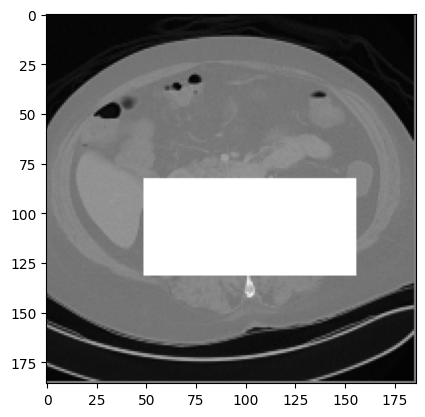

In [9]:
# show bbox on image
image_bbox = image.copy()
image_bbox[z:z+d, y:y+h, x:x+w] = 1000
plt.imshow(image_bbox[64, ...], cmap='gray')

In [10]:
affine = get_affine_from_bbox_3d(*get_bbox_3d(image, label), image.shape)
affine = np.concatenate([affine, np.array([[0, 0, 0, 1]])], axis=0)

In [11]:
image_t = ndimage.affine_transform(image, np.linalg.inv(affine), order=1)

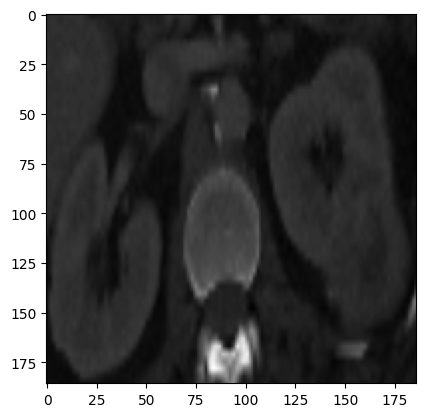

In [12]:
plt.imshow(image_t[64, ...], cmap='gray')

In [13]:
label_t = ndimage.affine_transform(label, np.linalg.inv(affine), order=0)

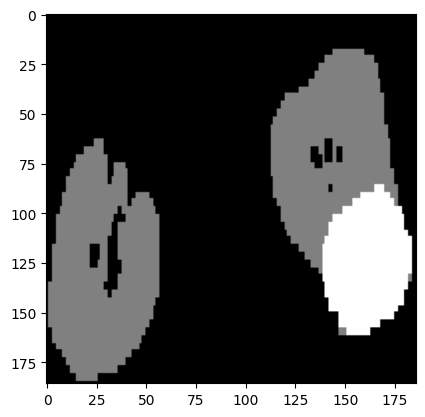

In [14]:
plt.imshow(label_t[64, ...], cmap='gray')

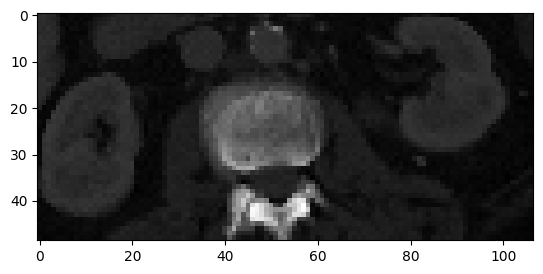

In [24]:
z, y, x, d, h, w = get_bbox_3d_from_affine(affine)
img_cropped = image[int(z):int(z+d), int(y):int(y+h), int(x):int(x+w)]
plt.imshow(img_cropped[32, ...], cmap='gray')

In [25]:
def get_theta_from_bbox_3d(z, y, x, d, h, w, original_shape):
  """
  Returns an affine transformation matrix in PyTorch-expected format that 
  will crop the image to the bounding box.
  """
  original_d, original_h, original_w = original_shape
  scale_x = original_w / w
  scale_y = original_h / h
  scale_z = original_d / d

  x_t = (x + w / 2) / original_w * 2 - 1
  y_t = (y + h / 2) / original_h * 2 - 1
  z_t = (z + d / 2) / original_d * 2 - 1

  theta = np.array([[1 / scale_x, 0, 0, x_t], [0, 1 / scale_y, 0, y_t], [0, 0, 1 / scale_z, z_t]], dtype=np.float32)
  return theta

def get_bbox_3d_from_theta(theta):
  """
  Returns the bounding box from an affine transformation matrix in PyTorch-expected format.
  """
  scale_x = theta[0, 0]
  scale_y = theta[1, 1]
  scale_z = theta[2, 2]
  x_t = theta[0, 3]
  y_t = theta[1, 3]
  z_t = theta[2, 3]
  x = (x_t + 1) / 2 * image.shape[2]
  y = (y_t + 1) / 2 * image.shape[1]
  z = (z_t + 1) / 2 * image.shape[0]
  d = image.shape[0] / scale_z
  h = image.shape[1] / scale_y
  w = image.shape[2] / scale_x
  return z, y, x, d, h, w

In [56]:
from albumentations.pytorch import ToTensorV2


image_tensor = torch.from_numpy(image).unsqueeze(0)
label_tensor = torch.from_numpy(label).unsqueeze(0)

In [57]:
image_tensor.shape

torch.Size([1, 186, 186, 186])

torch.Size([1, 186, 186, 186])


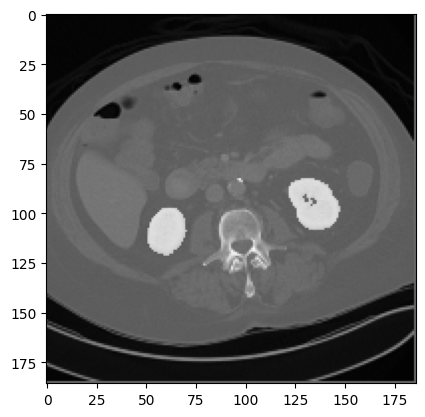

In [63]:
print(image_tensor.shape)

image_slice = image_tensor[:, 64, :, :]
label_slice = label_tensor[:, 64, :, :]
plt.imshow(image_slice.squeeze().numpy() + label_slice.squeeze().numpy() * 1000, cmap='gray')

In [92]:
import cv2 as cv

def get_theta_from_bbox(x, y, w, h, size):
  """
  Returns an affine transformation matrix in PyTorch-expected format that 
  will crop the image to the bounding box.
  """
  scale_x = size / w
  scale_y = size / h

  x_t = (x + w / 2) / size * 2 - 1
  y_t = (y + h / 2) / size * 2 - 1


  #t00 = 1 / (s / w) => w = s / t00
  #t11 = 1 / (s / h) => h = s / t11
  #t02 = (x + w / 2) / s * 2 - 1
  #t12 = (y + h / 2) / s * 2 - 1
  theta = np.array([[1 / scale_x, 0, x_t], [0, 1 / scale_y, y_t]], dtype=np.float32)
  return theta

def get_bbox_from_theta(theta, size):
  """
  Returns the bounding box parameters from an affine transformation matrix
  in PyTorch-expected format.
  """
  # inverse of get_theta_from_bbox

  t00 = theta[0, 0]
  t11 = theta[1, 1]
  t02 = theta[0, 2]
  t12 = theta[1, 2]

  # t00 = w / size
  w = t00 * size
  # t11 = h / size
  h = t11 * size

  # t02 = (x + w / 2) / size * 2 - 1
  x = (size * t02 + size - w) / 2
  # t12 = (y + h / 2) / size * 2 - 1
  y = (size * t12 + size - h) / 2

  return x, y, w, h

def get_bbox(input, label, padding=32, bbox_aug=0):
  """ 
  Get a crop bbox enclosing the label, with padding and bbox augmentation.

  Args:
    input: input image
    label: label image
    padding: padding around label
    bbox_aug: random bbox augmentation as a percentage of the bbox size, 
              each bbox parameter (x, y, w, h) is augmented 
              by a random value in [-bbox_aug * min(w, h), bbox_aug * min(w, h)]

  Returns:
    x, y, w, h: bbox parameters
  """
  original_size = label.shape[:2]

  label_th = label.copy()
  label_th[label_th > 0.5] = 1
  label_th[label_th <= 0.5] = 0
  label_th = label_th.astype(np.uint8)
  bbox = cv.boundingRect(label_th)

  x, y, w, h = bbox

  if w == 0 or h == 0 or x < 0 or y < 0:
    if label_th.sum() > 0:
      print('Warning: invalid bbox, using full image')
    x, y, w, h = 0, 0, *original_size
    return x, y, w, h

  if bbox_aug > 0:
    augs = np.random.uniform(-bbox_aug * min(w, h), bbox_aug * min(w, h), size=4)
    x += augs[0]
    y += augs[1]
    w += augs[2]
    h += augs[3]

  x -= padding
  y -= padding
  w += 2 * padding
  h += 2 * padding

  return x, y, w, h

In [115]:
x, y, w, h = get_bbox(image_slice.squeeze().numpy(), label_slice.squeeze().numpy(), padding=32, bbox_aug=0)
theta = get_theta_from_bbox(x, y, w, h, size=image_slice.shape[-1])
bbox_ = np.array(get_bbox_from_theta(theta, size=image_slice.shape[-1]))

print(x, y, w, h)
print(bbox_)

19 51 161 103
[ 18.9999992   50.99999917 161.00000167 103.00000155]


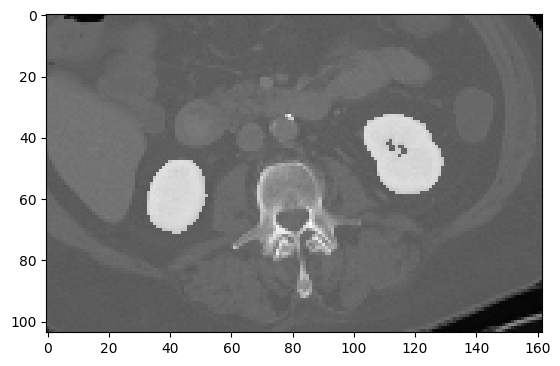

In [116]:
image_slice_crop = image_slice[:, int(bbox_[1]):int(bbox_[1] + bbox_[3]), int(bbox_[0]):int(bbox_[0] + bbox_[2])]
label_slice_crop = label_slice[:, int(bbox_[1]):int(bbox_[1] + bbox_[3]), int(bbox_[0]):int(bbox_[0] + bbox_[2])]
plt.imshow(image_slice_crop.squeeze().numpy() + label_slice_crop.squeeze().numpy() * 1000, cmap='gray')

torch.Size([1, 1, 186, 186])
torch.Size([1, 2, 3])


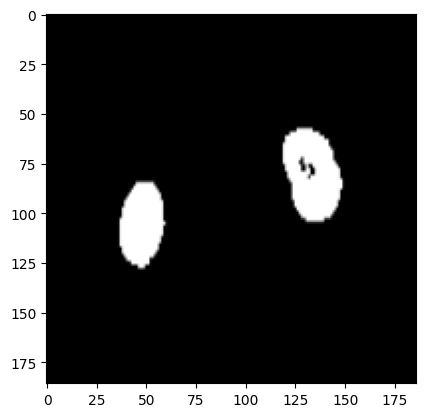

In [117]:
input = label_slice.unsqueeze(0).float()
print(input.shape)
theta_ = torch.from_numpy(theta).unsqueeze(0)
print(theta_.shape)
grid = F.affine_grid(theta_, label_slice.unsqueeze(0).size(), align_corners=True)
output = F.grid_sample(input, grid, align_corners=True)
plt.imshow(output.squeeze().numpy(), cmap='gray')

torch.Size([1, 1, 104, 162])
torch.Size([1, 2, 3])


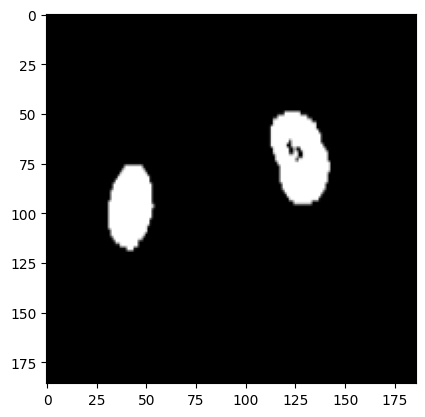

In [120]:
theta_ = theta.copy()
# remove scaling
theta_[0, 0] = 1
theta_[1, 1] = 1

theta_ = torch.from_numpy(theta_).unsqueeze(0)
input = label_slice_crop.unsqueeze(0).float()
print(input.shape)
print(theta_.shape)

grid = F.affine_grid(theta_, label_slice.unsqueeze(0).size(), align_corners=True)
input = F.grid_sample(input, grid, align_corners=True)

plt.imshow(input.squeeze().numpy(), cmap='gray')


In [18]:
import torch.nn.functional as F

theta = get_theta_from_bbox_3d(*get_bbox_3d(image, label), image.shape)
theta = torch.from_numpy(theta).unsqueeze(0)

input = label_tensor.unsqueeze(0).float()
print(theta.shape)
grid = F.affine_grid(theta, input.shape, align_corners=True)
image_tt = F.grid_sample(input, grid, align_corners=True)

torch.Size([1, 3, 4])


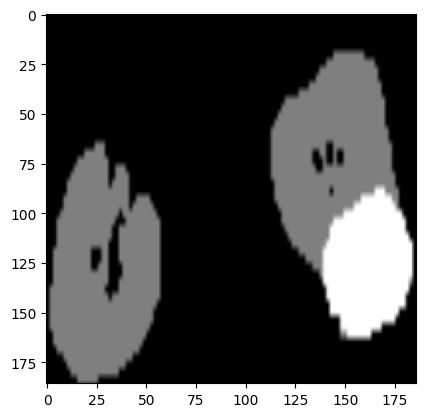

In [19]:
image_tt = image_tt.squeeze().numpy()
plt.imshow(image_tt[64, ...], cmap='gray')

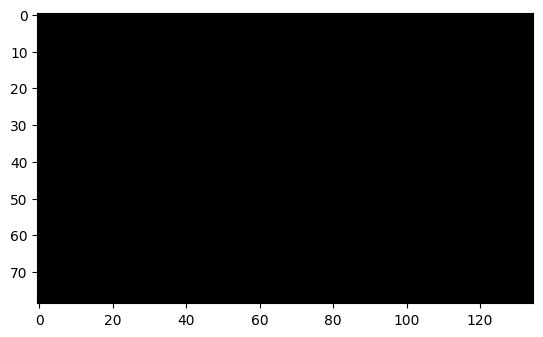

In [34]:
x, y, z, w, h, d = get_bbox_3d_from_theta(theta.squeeze().numpy())
img_cropped = input.squeeze().numpy()[int(z):int(z+d), int(y):int(y+h), int(x):int(x+w)]
plt.imshow(img_cropped[32, ...], cmap='gray')

In [20]:
import monai
unet = monai.networks.nets.FlexibleUNet(
  in_channels=1,
  out_channels=1,
  backbone='efficientnet-b0',
  pretrained=True,
)


In [21]:
unet

FlexibleUNet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (_blocks): Sequential(
      (0): Sequential(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_expand_conv_padding): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
          (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (_se_reduce_padding): Identity()
          (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), s

(1, 186, 186, 186)


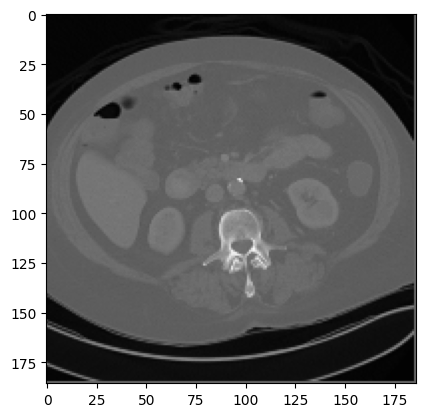

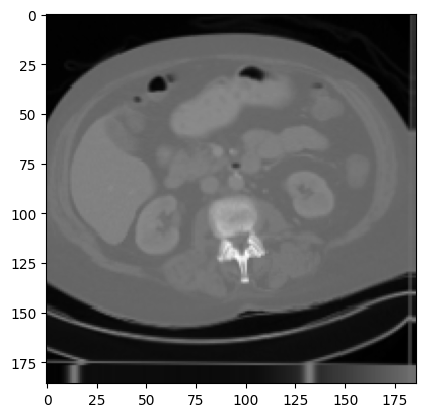

In [22]:
import monai
import monai.transforms as T
import time

transform = T.Compose([
  T.RandAffined(prob=1, keys=['image'], mode='bilinear', padding_mode='reflection',
    rotate_range=(0.15, 0.15, 0.15), translate_range=(0.1, 0.1, 0.1), scale_range=(0.1, 0.1, 0.1)),
  T.RandGridDistortiond(prob=1, keys=['image'], distort_limit=0.1),
])

transform.set_random_state(time.time() * 1000)

# add channel dim
image_ = image[None, ...]
print(image_.shape)

image_transformed = transform({'image': image_})['image']
plt.imshow(image[64, ...], cmap='gray')
plt.show()
plt.imshow(image_transformed[0][64, ...], cmap='gray')

(3, 240, 240)


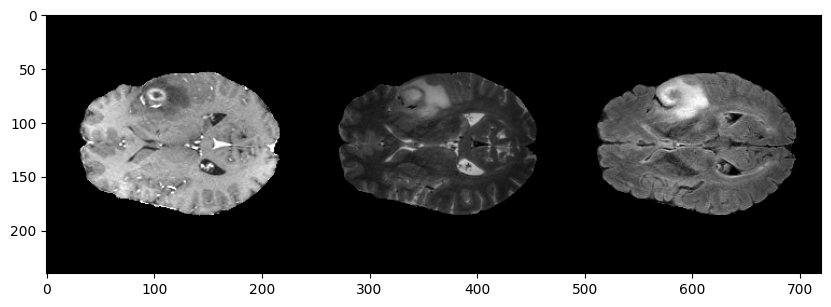

In [162]:
brats_slice = np.load('data/brats/test/input/BraTS20_Training_002_68.npy')
window_min = 50
window_max = 700
brats_slice[brats_slice < window_min] = window_min
brats_slice[brats_slice > window_max] = window_max
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack(brats_slice), cmap='gray')
print(brats_slice.shape)

In [134]:
channels = [0, 1, 2]
for channel in channels:
    print(brats_slice[channel].min(), brats_slice[channel].max())

0.0 1374.0
0.0 573.0
0.0 713.0


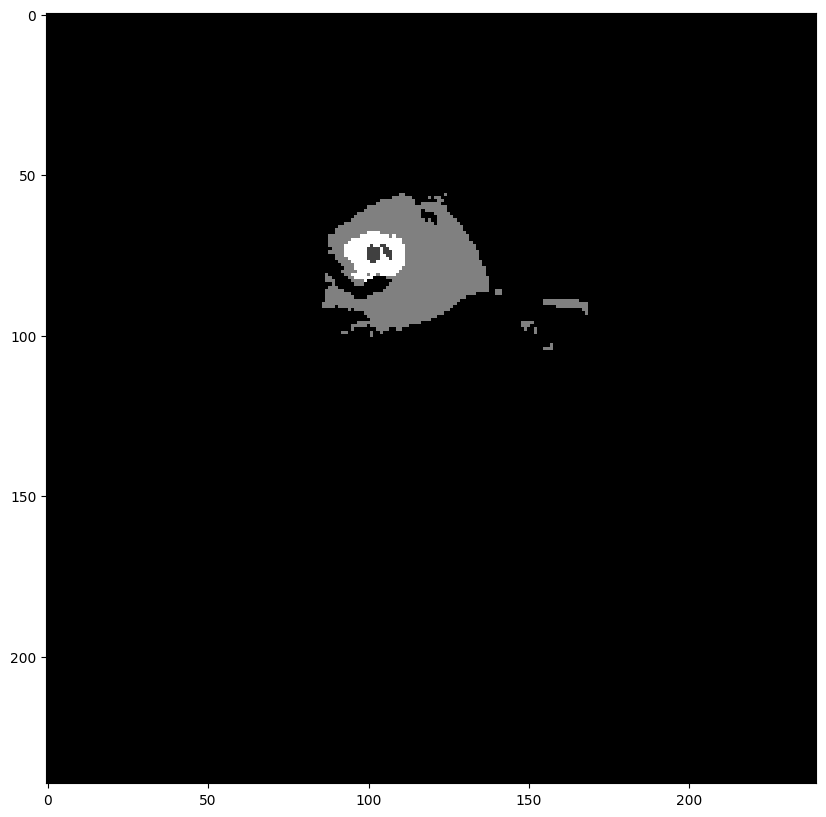

In [165]:
brats_label = np.load('data/brats/test/label/BraTS20_Training_002_68.npy')
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack(brats_label), cmap='gray')